In [31]:
import datetime
from itertools import combinations
from typing import NamedTuple
from matplotlib import pyplot as plot
from git import Repo
import networkx as nx


In [32]:
repo = Repo("../quizzology")

In [33]:
repo_graph = nx.Graph()
for commit in repo.iter_commits():
    for (left,right) in combinations(commit.stats.files,2):
        if (left,right) in repo_graph.edges:
            data = repo_graph.get_edge_data(left,right)
            data['count'] = data.get('count',1) + 1
        else:
            repo_graph.add_edge(left,right)


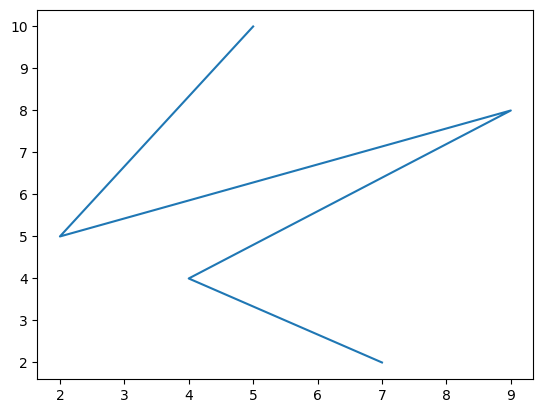

In [34]:
# Create a plot 

x = [5, 2, 9, 4, 7]
y = [10, 5, 8, 4, 2]
plot.plot(x, y)
plot.show()

In [35]:
# Draw a network plot of some kind

# graph = nx.petersen_graph() # well known sample data 
# subax = plot.subplot(121)
# nx.draw(graph)

# repo_plot = plot.subplot(122)
# nx.draw(repo_graph, with_labels=True)



In [36]:
left, right = next(iter(repo_graph.edges))
print( (left,right) in repo_graph.edges )




True


22


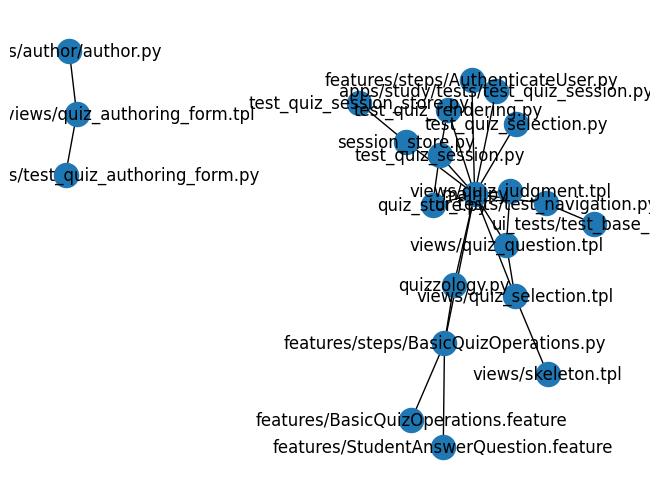

In [42]:
# Perhaps we should trim the data set so that we don't plot every single 
# edge and node in one ugly graph.
busiest_graph = nx.Graph()
for (l,r) in repo_graph.edges:
    data = repo_graph.get_edge_data(l,r)
    ordinal = data.get('count',0)
    if ordinal > 8:
        busiest_graph.add_edge(l,r)
nx.draw(busiest_graph, with_labels=True)


    
    